**Modelling**

In this section, we are looking to:
1. employ the use of several machine learning models to our dataset
2. evaluate the performance of every model via cross-validation
3. assess the model using appropriate metrics to determine its performance
4. choose the best-performing model

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reading the top rows of the data to ensure that the values in the diagnosis has been changed and the features have been scaled.

In [62]:
dataset = pd.read_csv("../data/dataset_preprocessed.csv")
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,1,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


As usual, we split the dataset into X and y for easier reference, along with the header.

In [63]:
X = dataset.loc[:, dataset.columns != "diagnosis"].to_numpy()
y = np.ravel(dataset.loc[:, dataset.columns == "diagnosis"].to_numpy())
header = list(dataset.columns)

We will employ the use of cross-validation of 10 folds to verify the performance of our models.

In [64]:
from sklearn.model_selection import StratifiedKFold

In [65]:
seed = 238

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

The different training indexes and testing indexes obtained from each fold is stored into splits for iteration later.

In [66]:
splits = []

for train_index, test_index in skf.split(X, y):
    splits.append((train_index, test_index))

The three metrics we will be using to assess the models are: 
1. Accuracy
2. F1 score
3. ROC AUC

In [67]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

The function get_metrics returns a list of the metrics obtained from assessing the model. There are 10 folds in the cross-validation, so there are 10 iterations, each X and y using their respective training and testing indexes based on the way stratified kfold had split the indices.

In [68]:
def get_metrics(X, y, splits, model):
    accuracy_list = []
    f1_list = []
    roc_auc_list = []
    fpr_list = []
    tpr_list = []

    for i in range(len(splits)):
        train_index = splits[i][0]
        test_index = splits[i][1]

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        accuracy_list.append(accuracy)
        f1_list.append(f1)
        roc_auc_list.append(roc_auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    return accuracy_list, f1_list, roc_auc_list, fpr_list, tpr_list

The function get_mean_metrics then calculates the mean of all the metrics and returns them.

In [69]:
def get_mean_metrics(accuracy_list, f1_list, roc_auc_list, fpr_list, tpr_list):
    accuracy_mean = np.mean(accuracy_list)
    f1_mean = np.mean(f1_list)
    roc_auc_mean = np.mean(roc_auc_list)
    fpr_mean = np.mean(fpr_list, axis=0)
    tpr_mean = np.mean(tpr_list, axis=0)

    return accuracy_mean, f1_mean, roc_auc_mean, fpr_mean, tpr_mean

Since diagnosis is either "B" or "M", we require machine learning models that does binary classification. Thus, we will be using the following models:
1. Logistic Regression
2. k-Nearest Neighbours
3. Random Forest
4. Source Vector Machine

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

We will be using the same seed as previously defined in stratified k-fold.

In [71]:
k = round(np.sqrt(X.shape[0] * 0.9))
if k & 2 == 0:
    k += 1

models = {"k-Nearest Neighbors": KNeighborsClassifier(n_neighbors = k),
          "Logistic Regression": LogisticRegression(max_iter = 1000, random_state = seed),
          "Random Forest": RandomForestClassifier(random_state = seed),
          "Source Vector Machine": SVC(kernel = "rbf", C = 1.0)}

We will iterate through all of the models in the dictionary, and print their accuracies, f1 scores and roc auc, along with the ROC curve. We will also be keeping track of the model that produces the highest accuracy, f1 score and roc auc.

Current model: k-Nearest Neighbors

Accuracy mean: 0.9560776942355889
F1 score mean: 0.9352214730070955
ROC AUC mean: 0.9416847041847042

Accuracy list: [0.96491228 1.         1.         0.94736842 0.92982456 0.98245614
 0.92982456 0.89473684 0.94736842 0.96428571]
F1 score list: [0.95238095 1.         1.         0.92307692 0.89473684 0.97560976
 0.9        0.83333333 0.92307692 0.95      ]
ROC AUC list: [0.95454545 1.         1.         0.92857143 0.9047619  0.97619048
 0.91468254 0.85714286 0.92857143 0.95238095]


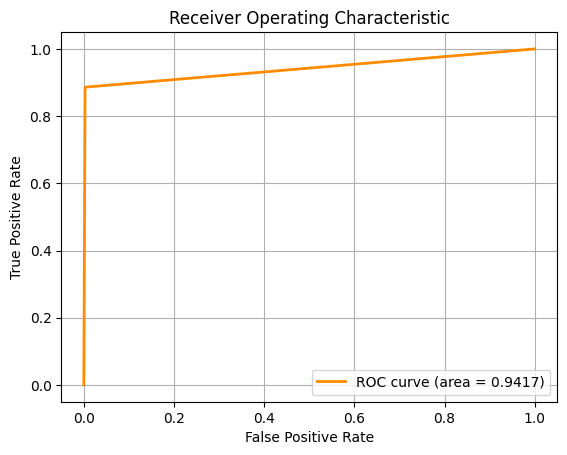

------------------------------------------------------------
Current model: Logistic Regression

Accuracy mean: 0.9736215538847116
F1 score mean: 0.9634815572024875
ROC AUC mean: 0.9683910533910535

Accuracy list: [1.         0.94736842 1.         0.96491228 0.96491228 0.98245614
 0.96491228 0.94736842 1.         0.96428571]
F1 score list: [1.         0.93023256 1.         0.95238095 0.95       0.97674419
 0.95       0.92307692 1.         0.95238095]
ROC AUC list: [1.         0.94025974 1.         0.96230159 0.95238095 0.98611111
 0.95238095 0.92857143 1.         0.96190476]


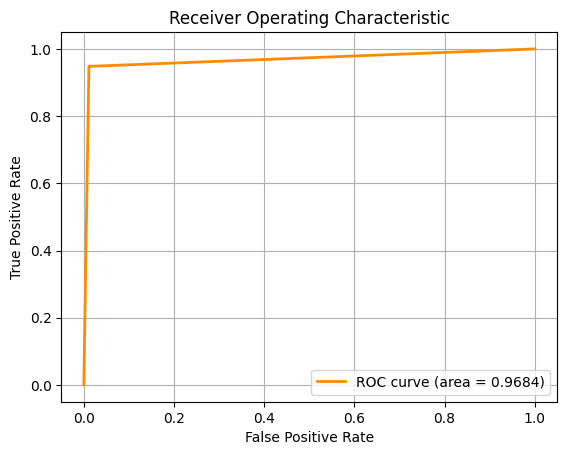

------------------------------------------------------------
Current model: Random Forest

Accuracy mean: 0.9648496240601503
F1 score mean: 0.9520108753035581
ROC AUC mean: 0.960386002886003

Accuracy list: [1.         0.96491228 1.         0.98245614 0.96491228 1.
 0.92982456 0.9122807  0.92982456 0.96428571]
F1 score list: [1.         0.95454545 1.         0.97560976 0.95238095 1.
 0.9047619  0.87804878 0.9047619  0.95      ]
ROC AUC list: [1.         0.96298701 1.         0.97619048 0.96230159 1.
 0.92460317 0.90079365 0.92460317 0.95238095]


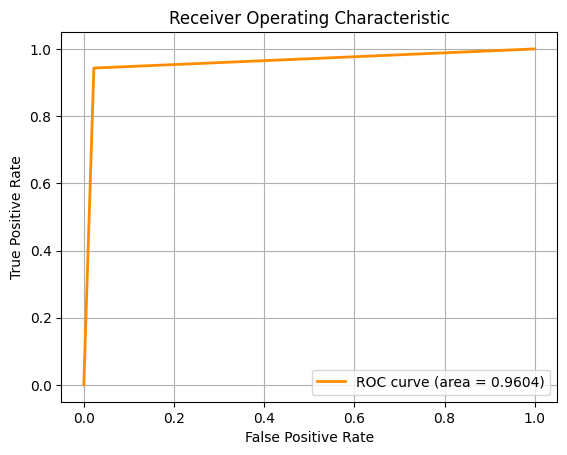

------------------------------------------------------------
Current model: Source Vector Machine

Accuracy mean: 0.9788847117794486
F1 score mean: 0.9709283868586194
ROC AUC mean: 0.9753174603174604

Accuracy list: [1.         0.98245614 1.         0.96491228 0.96491228 0.98245614
 0.96491228 0.96491228 1.         0.96428571]
F1 score list: [1.         0.97777778 1.         0.95238095 0.95       0.97674419
 0.95       0.95       1.         0.95238095]
ROC AUC list: [1.         0.98571429 1.         0.96230159 0.95238095 0.98611111
 0.95238095 0.95238095 1.         0.96190476]


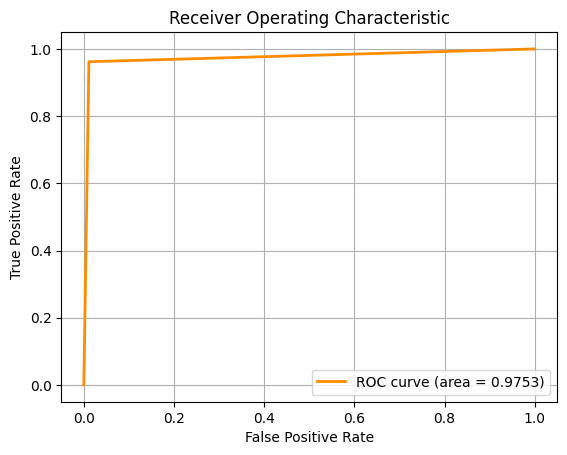

------------------------------------------------------------


In [72]:
highest_accuracy = ["", 0]
highest_f1 = ["", 0]
highest_roc_auc = ["", 0]

for name in models:
    model = models[name]

    acc_list, f1_list, ra_list, fpr_list, tpr_list = get_metrics(X, y, splits, model)
    acc_mean, f1_mean, ra_mean, fpr_mean, tpr_mean = get_mean_metrics(acc_list, f1_list, ra_list, fpr_list, tpr_list)

    if acc_mean > highest_accuracy[1]:
        highest_accuracy[0] = name
        highest_accuracy[1] = acc_mean

    if f1_mean > highest_f1[1]:
        highest_f1[0] = name
        highest_f1[1] = f1_mean
    
    if ra_mean > highest_roc_auc[1]:
        highest_roc_auc[0] = name
        highest_roc_auc[1] = ra_mean

    print(f"Current model: {name}")
    print()
    print(f"Accuracy mean: {acc_mean}")
    print(f"F1 score mean: {f1_mean}")
    print(f"ROC AUC mean: {ra_mean}")
    print()
    print(f"Accuracy list: {np.array(acc_list)}")
    print(f"F1 score list: {np.array(f1_list)}")
    print(f"ROC AUC list: {np.array(ra_list)}")

    plt.figure()
    plt.plot(fpr_mean, tpr_mean, color = "darkorange", lw = 2, 
             label = "ROC curve (area = %0.4f)" % ra_mean)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("-" * 60)

As seen below, the Source Vector Machine (SVC) model performed the best across the board for all metrics.

In [73]:
print(f"Model with highest average accuracy: {highest_accuracy}")
print(f"Model with highest F1 score: {highest_f1}")
print(f"Model with highest ROC AUC: {highest_roc_auc}")

Model with highest average accuracy: ['Source Vector Machine', 0.9788847117794486]
Model with highest F1 score: ['Source Vector Machine', 0.9709283868586194]
Model with highest ROC AUC: ['Source Vector Machine', 0.9753174603174604]


We will now save the best performing model (SVC) into a .bin file to be used in predict.py.

In [74]:
import pickle

In [75]:
model = models[highest_roc_auc[0]]

with open("model.bin", "wb") as f:
    pickle.dump(model, f)

print("Model saved")

Model saved
